In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms
import random
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset
from collections import Counter
from collections import defaultdict
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
from collections import OrderedDict
import torch.nn as nn
import time
import os
import torch
import copy
import torch.nn.functional as F
import wandb
import json
import heapq
import pandas as pd
import pickle


# Seeds for reproducibility
def set_seeds(seed: int = 123):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
""" PLOT SETTINGS """

plt.style.use("seaborn-v0_8")
plt.rcParams.update({
    "font.size": 18,            # base font size
    "axes.titlesize": 24,       # axis titles
    "axes.labelsize": 22,       # axis labels
    "xtick.labelsize": 18,      # X axis numbers
    "ytick.labelsize": 18,      # Y axis numbers
    "legend.fontsize": 18,      # legend text
    "lines.linewidth": 3.0      # line thickness
})


In [21]:
# --- Define DINOWithHead ---
class DINOWithHead(nn.Module):
    def __init__(self, backbone, num_classes=100, p=None):
        super().__init__()
        self.backbone = backbone
        layers = []
        if p is not None:
            layers.append(nn.Dropout(p=p))
        layers.append(nn.Linear(384, num_classes))
        self.head = nn.Sequential(*layers)

    def forward(self, x):
        features = self.backbone(x)
        out = self.head(features)
        return out

## Data import and loader creation

In [22]:
""" DATASET DOWNLOAD """
ROOT = './data'
BATCH_SIZE=64
#BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

tot_train_data = torchvision.datasets.CIFAR100(root=ROOT, train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.CIFAR100(root=ROOT, train=False, download=True, transform=torchvision.transforms.ToTensor())





""" SPLIT TOT_TRAININ in VALIDATION and TRAIN """

def split_dataset(tot_train_data, valid_ratio=0.8):
    """
    Splits the given dataset randomly into training and validation subsets
    """
    train_size = int(valid_ratio * len(tot_train_data))
    val_size = len(tot_train_data) - train_size
    train_data, val_data = random_split(tot_train_data, [train_size, val_size])
    return train_data, val_data

train_data, val_data = split_dataset(tot_train_data, valid_ratio=0.8)



""" DATA TRANSFORMATION """

def data_trasform(dataset, data_augmentation=False):   ### train_data or tot_train_data
    """
    Returns train and val/test transforms based on dataset stats.
    Dataset (for computing mean and std) can be either training only or combined train+validation.

    If data_augmentation=True, applies augmentation on training transforms, otherwise only resize and normalize.
    """

    # MEAN and VARIANCE (considering 3 channels)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0

    for img, _ in dataset:
        img = img.view(3, -1)  # Flatten H*W in seconda dimensione
        mean += img.mean(1)
        std += img.std(1)
        nb_samples += 1

    mean /= nb_samples
    std /= nb_samples


    if data_augmentation:
        train_transforms = transforms.Compose([
            transforms.Resize(64, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.RandomCrop(64, padding=4),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.RandAugment(num_ops=2, magnitude=9),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    else:
        train_transforms = transforms.Compose([
            transforms.Resize(64, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    ### NO DATA AUGMENTATION!
    val_test_transforms = transforms.Compose([
        transforms.Resize(64),                    # Resize
        transforms.ToTensor(),                     # Convert to tensor
        transforms.Normalize(mean=mean, std=std)   # Normalization using the training statistics
    ])


    return train_transforms, val_test_transforms






""" DATA TRANSFORMATION and LOADERS """

### ===== For hyperparameter tuning considering train_data and val_data =====
train_transforms, val_test_transforms = data_trasform(train_data)

train_data.dataset.transform = train_transforms
val_data.dataset.transform = val_test_transforms

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



### ===== For model testing considering tot_train_data and test_data =====
train_transforms, val_test_transforms = data_trasform(tot_train_data)

tot_train_data = torchvision.datasets.CIFAR100(root=ROOT, train=True, download=False, transform=train_transforms)
test_data = torchvision.datasets.CIFAR100(root=ROOT, train=False, download=False, transform=val_test_transforms)

tot_train_loader = DataLoader(tot_train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


## Functions Client

In [23]:
""" SPLIT INTO K CLIENTS: iid and non-iid distributions  """

def iid_shard(dataset, K):
    """
    Splits the dataset into K disjoint subsets (one per client) in an IID fashion. Each client receives ~len(dataset)/K samples,
    drawn uniformly at random across all classes.
    """
    num_items_per_client = len(dataset) // K
    remainder = len(dataset) % K
    all_indices = list(range(len(dataset)))
    random.shuffle(all_indices)

    client_data = {}  # Creation of a dictionary for clients
    start = 0
    for i in range(K):
        # give +1 to the first `remainder` clients
        add = num_items_per_client + (1 if i < remainder else 0)
        end = start + add
        client_data[i+1] = Subset(dataset, all_indices[start:end])
        start = end

    return client_data


def noniid_shard(dataset, K, Nc):
    """
    Splits the dataset into K disjoint subsets (one per client) in a non-IID fashion.
    Disjoint dataset: each sample must belong to exactly one client and cannot be duplicated.
    Nc: each client receives samples from Nc distinct classes, to simulate variability of data across clients.
    """
    # === Feasibility check ===
    all_classes = set(label for _, label in dataset)
    num_classes = len(all_classes)
    if Nc > num_classes:
        raise ValueError(f"Cannot assign {Nc} classes per client: only {num_classes} classes available.")


    # === Step 1: Organize data by class ===
    # This ensures we can select samples from specific classes without duplication.
    label_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        label_to_indices[label].append(idx)    # key: class, value: list of idxs of the corresponding class

    # === Step 2: Shuffle samples within each class ===
    # Prevents consecutive samples from going to the same clients repeatedly.
    for cls in label_to_indices:
        random.shuffle(label_to_indices[cls])

    # === Step 3: Prepare the list of clients and shuffle it ===
    # Guarantees random assignment of classes to clients.
    all_classes = list(label_to_indices.keys())

    client_class_map = {}
    for client_id in range(1, K+1):        # Pre-select Nc classes per client at the beginning.
        client_class_map[client_id] = random.sample(all_classes, Nc)

    client_data = {cid: [] for cid in range(1, K+1)}    # Initialize empty client datasets
    class_to_clients = defaultdict(list)     # For each class, keep track of clients that have it (reverse map from class → clients that have that class)
    for cid, classes in client_class_map.items():
        for cls in classes:
            class_to_clients[cls].append(cid)


    # === Step 4: Distribute samples in rounds ===
    # Distributing samples to clients in rounds
    for cls, indices in label_to_indices.items():    # Iterate over all classes, where indices is the list of the samples for the considered class
        clients = class_to_clients[cls]  # clients that want this class
        if not clients:
            continue
        i = 0
        while indices:
            client_id = clients[i % len(clients)]  # cycling continuously through the list of clients
            sample = indices.pop()                 # take one sample and it removes it so it will not be repeated
            client_data[client_id].append(sample)  # assign to this client
            i += 1

     # === Step 5: Convert sample index lists into Subsets ===
    for cid in client_data:
        client_data[cid] = Subset(dataset, client_data[cid])

    return client_data

## Class Client

In [24]:
def compress_mask(mask_dict):
    """
    Convert each 0/1 tensor in the mask into a compressed bit array.
    Returns a dictionary: {param_name: (packed_uint8_array, original_shape)}
    """
    compressed = {}
    for name, tensor in mask_dict.items():
        # Move tensor to CPU, cast to uint8, flatten, and convert to numpy
        arr = tensor.detach().to('cpu').to(torch.uint8).contiguous().view(-1).numpy()
        # Pack bits into a compact representation (8x smaller than uint8)
        packed = np.packbits(arr)
        compressed[name] = (packed, tuple(tensor.shape))  # store packed data + original shape
    return compressed


def decompress_mask(compressed_dict):
    """
    Reconstruct torch.uint8 tensors with the original shape (0/1 values).
    """
    mask = {}
    for name, (packed, shape) in compressed_dict.items():
        total = int(np.prod(shape))  # number of elements in original tensor
        # Unpack bits back to 0/1 and trim extra padding
        unpacked = np.unpackbits(packed)[:total]
        # Reshape to original tensor shape and convert to torch.uint8
        mask[name] = torch.from_numpy(unpacked.reshape(shape)).to(torch.uint8)
    return mask

""" CLASS CLIENT"""
class Client:
    def __init__(self, client_id, dataset, loader,
                 mask=None, extra_mask=None, fisher_scores=None,
                 local_weights=None, local_fisher=None, compressed_mask=None):
        self.client_id = client_id
        self.dataset = dataset
        self.loader = loader

        # Full mask in RAM (0/1 tensors) – only needed during training
        self.mask = mask

        # Lightweight storage version (bit-packed mask)
        self.compressed_mask = compressed_mask

        # Optional: additional mask (depends on your logic)
        self.extra_mask = extra_mask

        # Fisher scores are only needed during calibration; cast to float16 if provided
        self.fisher_scores = fisher_scores.half() if fisher_scores is not None else None

        # Local weights (float16)
        self.local_weights = local_weights.half() if local_weights is not None else None

        # Local Fisher information (float16)
        self.local_fisher = local_fisher.half() if local_fisher is not None else None

    def compress_mask(self):
        """
        Compress self.mask into self.compressed_mask and free RAM
        """
        if self.mask is not None:
            # Make sure mask tensors are uint8 (0/1 values)
            self.mask = {k: v.to(torch.uint8) for k, v in self.mask.items()}
            self.compressed_mask = compress_mask(self.mask)
            self.mask = None  # release memory

    def decompress_mask(self):
        """
        Rebuild self.mask (0/1 tensors) from self.compressed_mask
        """
        if self.compressed_mask is not None and self.mask is None:
            self.mask = decompress_mask(self.compressed_mask)

    def num_samples(self):
        """
        Returns the number of samples in the client’s local dataset.
        """
        return len(self.dataset)

    @staticmethod
    def print_samples(clients):
        """
        Prints the number of samples each client holds.
        """
        print("Number of samples per client:")
        for client in clients:
            print(f"Client {client.client_id}: {client.num_samples()} samples")

    @staticmethod
    def plot_class_distribution(clients, dataset):
        """
        Plots the distribution of classes for a list of clients.
        """
        class_distributions = []

        if hasattr(dataset, 'targets'):
            get_label = lambda idx: dataset.targets[idx]
        elif hasattr(dataset, 'labels'):
            get_label = lambda idx: dataset.labels[idx]
        else:
            get_label = lambda idx: dataset[idx][1]

        for client in clients:
            indices = client.loader.dataset.indices if isinstance(client.loader.dataset, Subset) else list(range(len(client.loader.dataset)))
            labels = [get_label(i) for i in indices]
            class_counts = Counter(labels)
            class_distributions.append(class_counts)

        fig, axes = plt.subplots(nrows=1, ncols=len(clients), figsize=(5 * len(clients), 4))
        if len(clients) == 1:
            axes = [axes]

        for i, (client, class_counts) in enumerate(zip(clients, class_distributions)):
            axes[i].bar(class_counts.keys(), class_counts.values(), color='orange')
            axes[i].set_title(f'Client {client.client_id}')
            axes[i].set_xlabel('Classes')
            axes[i].set_ylabel('Frequency')
            axes[i].set_xticks(list(class_counts.keys()))

        plt.tight_layout()
        plt.show()

""" CLIENT CREATION """
def create_clients(data, K, Nc=None, flag="iid", batch_size=64):
    """
    Splits the dataset into K subsets, either IID or non-IID, and returns both the client datasets and their corresponding DataLoaders
    """
    if flag == "iid":
        client_datasets = iid_shard(data, K)  # Split the training data into K clients
    else:
        client_datasets = noniid_shard(data, K, Nc)

    client_loaders = {}
    for client_id, subset in client_datasets.items():
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        client_loaders[client_id] = loader
    return client_datasets, client_loaders


def create_client_objects(data, K, Nc=None, flag="iid", batch_size=64, 
                          verbose=True, local_weights_dict=None, local_fisher_dict=None):
    """
    Creates and returns a list of Client objects, each containing its own dataset and DataLoader,
    with optional local_weights and local_fisher.
    """

    if flag == "non-iid" and Nc is None:
        raise ValueError("Nc must be set when flag='non-iid'")

    client_datasets, client_loaders = create_clients(data, K, Nc, flag=flag, batch_size=batch_size)
    clients = []

    for client_id in client_datasets.keys():
        lw = local_weights_dict.get(client_id, None) if local_weights_dict else None
        lf = local_fisher_dict.get(client_id, None) if local_fisher_dict else None

        clients.append(Client(
            client_id=client_id,
            dataset=client_datasets[client_id],
            loader=client_loaders[client_id],
            local_weights=lw,
            local_fisher=lf
        ))

    if verbose:
        print("Clients and their sample sizes:")
        for client in clients:
            print(f"Client {client.client_id}: {client.num_samples()} samples")

    return clients


## Server model evaluation

In [25]:
""" MODEL EVALUATION """
def evaluate_model(model, data_loader, criterion):
    """
    The evaluate_model function computes the average loss and accuracy of a model on a dataset without updating its weights.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_corrects += torch.sum(preds == labels.data)

    avg_loss = total_loss / len(data_loader.dataset)
    avg_acc = total_corrects.double() / len(data_loader.dataset)

    return avg_loss, avg_acc.item()



In [26]:
""" CHECKPOINT FUNCTION """
def save_checkpoint(model, epoch, train_losses, train_accuracies,
                    val_test_losses, val_test_accuracies, best_acc, best_loss, best_model_wts, path):
    """
    The save_checkpoint function saves the model’s state, training/validation metrics,
    and best performance to a specified file path.
    """
    dir_name = os.path.dirname(path)
    if dir_name:
        os.makedirs(dir_name, exist_ok=True)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_test_losses': val_test_losses,
        'val_test_accuracies': val_test_accuracies,
        'best_acc': best_acc,
        'best_loss': best_loss,
        'best_model_state_dict': best_model_wts
    }
    torch.save(checkpoint, path)



def init_checkpoint(model, path=None, device='cpu', verbose = True):
    """
    Initialize a checkpoint. If path is None, create default checkpoint with empty/default values.
    If path is given and file exists, load it.
    Returns: start_epoch, best_acc, best_loss, train_losses, train_accuracies, val_test_losses, val_test_accuracies, checkpoint_path, best_model_wts
    """
    if path is None:
        # default path
        os.makedirs("checkpoints", exist_ok=True)
        path = "checkpoints/latest.pth"
        if verbose:
            print(f"Initializing new checkpoint at {path}")
        # save default empty checkpoint
        checkpoint = {
            'epoch': 1,
            'best_acc': 0.0,
            'best_loss': 1e10,
            'train_losses': [],
            'train_accuracies': [],
            'val_test_losses': [],
            'val_test_accuracies': [],
            'model_state_dict': model.state_dict(),
            'best_model_state_dict': copy.deepcopy(model.state_dict())
        }
        torch.save(checkpoint, path)
        return 1, 0.0, 1e10, [], [], [], [], path, copy.deepcopy(model.state_dict())

    else:
        # load existing checkpoint
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Checkpoint file {path} does not exist.")

        print(f"Loading checkpoint from {path}")
        checkpoint = torch.load(path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = checkpoint.get('best_model_state_dict', copy.deepcopy(model.state_dict()))
        return (checkpoint['epoch'],
                checkpoint.get('best_acc', 0.0),
                checkpoint.get('best_loss', 1e10),
                checkpoint.get('train_losses', []),
                checkpoint.get('train_accuracies', []),
                checkpoint.get('val_test_losses', []),
                checkpoint.get('val_test_accuracies', []),
                path,
                best_model_wts )



## Train client

In [27]:
""" TRAINING FUNCTION """
def train_model_client(model, criterion, optimizer, scheduler, client: Client, J=5, device=None):    ### Single client
    """
    Trains a model locally on a single client for J epochs.
    Performs forward pass, computes loss, backpropagation, and updates weights using the given optimizer.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_loader = client.loader

    # ========== TRAINING ==========
    for j in range(J):   # "inner" loop
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels).item()

        if scheduler is not None:
            scheduler.step()

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_corrects / len(train_loader.dataset)

    return epoch_train_loss, epoch_train_acc    # Return the last performances


## Mask & Fine tuning

In [ ]:
""" MASK COMPUTATION & CALIBRATION """

def compute_fisher_scores(client, model, device):
    """
    Compute diagonal Fisher Information scores and store them in client.fisher_scores.
    Uses client.loader as the dataloader.
    """
    model.eval()

    # Initialize Fisher scores on the client if not already present
    if not hasattr(client, 'fisher_scores') or client.fisher_scores is None:
        client.fisher_scores = {name: torch.zeros_like(param, device="cpu")
                                for name, param in model.named_parameters() if param.requires_grad}

    for i, (inputs, labels) in enumerate(client.loader):
        #if i > 5:  # max 5 batches
        #    break

        inputs, labels = inputs.to(device), labels.to(device)

        model.zero_grad()
        outputs = model(inputs)

        # log-probabilities
        log_probs = F.log_softmax(outputs, dim=1)

        # Sample y ~ p(y|x)
        sampled_y = torch.multinomial(log_probs.exp(), num_samples=1).squeeze(-1)

        # NLL loss on sampled labels
        loss = F.nll_loss(log_probs, sampled_y)
        loss.backward()

        # Accumulate squared gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                client.fisher_scores[name] += (param.grad.detach().cpu() ** 2)

    # Normalize
    for name in client.fisher_scores.keys():
        client.fisher_scores[name] /= len(client.loader.dataset)


def calibrate_mask_for_client(client, model, device, R=5, final_sparsity=0.9, lr=0.005, weight_decay=0.00005 , keep="least"):
    # Initial mask: all ones (uint8) only for trainable parameters
    mask = {name: torch.ones_like(param, device="cpu", dtype=torch.uint8)
            for name, param in model.named_parameters() if param.requires_grad}
    client.mask = mask  # Stored in RAM

    # Recompute Fisher and update the mask R times
    for r in range(1, R + 1):
        current_density = (1 - final_sparsity) ** (r / R)
        current_sparsity = 1 - current_density
        print(f"[Round = {r}] Sparsity = {current_sparsity:.4f}")

        compute_fisher_scores(client, model, device)
        fisher_scores = client.fisher_scores  # dict {name: tensor float}

        # --- Flatten all scores ---
        all_scores = torch.cat([score.view(-1) for score in fisher_scores.values()])

        # --- Compute global threshold using topk ---
        num_keep_global = int(len(all_scores) * current_density)
        num_keep_global = max(1, min(num_keep_global, len(all_scores)))

        if keep == "least":
            # keep the least important weights
            _, idx = torch.topk(all_scores, k=num_keep_global, largest=False)
        elif keep == "most":
            # keep the most important weights
            _, idx = torch.topk(all_scores, k=num_keep_global, largest=True)
        elif keep == "random":
            idx = torch.randperm(len(all_scores))[:num_keep_global]
        else:
            raise ValueError("keep must be 'least', 'most', or 'random'")

        # build global_keep
        global_keep = torch.zeros_like(all_scores, dtype=torch.bool)
        global_keep[idx] = True

        # --- Redistribute threshold layer by layer ---
        new_mask = {}
        start = 0
        for name, score in fisher_scores.items():
            numel = score.numel()
            keep_tensor = global_keep[start:start+numel].view_as(score)
            new_mask[name] = (keep_tensor.to(torch.uint8) * client.mask[name])
            start += numel

        # update current mask
        client.mask = new_mask
        total_ones = sum(mask.sum().item() for mask in client.mask.values())
        total_params = sum(mask.numel() for mask in client.mask.values())
        perc_active = 100 * total_ones / total_params
        print(f"Active parameters: {total_ones}/{total_params} ({perc_active:.2f}%)")

        # mini-training with SparseSGD + current mask
        param_to_name = {id(param): n for n, param in model.named_parameters()}
        optimizer = SparseSGD(model.parameters(), lr=lr, weight_decay=weight_decay, mask_dict=client.mask, param_to_name=param_to_name)
        local_model = copy.deepcopy(model).to(device)
        train_model_client(local_model, criterion=nn.CrossEntropyLoss(), optimizer=optimizer,
                           scheduler=None, client=client, J=1, device=device)

    # End of calibration: do not keep Fisher scores in memory
    client.fisher_scores = None

    # Compress mask for lighter storage
    client.compress_mask()


def calibrate_all_clients(clients, global_model, device, R=5, final_sparsity=0.9, lr=0.005, weight_decay=0.00005, keep ="least"):
    """
    Apply mask calibration for all clients.
    """
    for client in clients:
        calibrate_mask_for_client(client, global_model, device, R=R, final_sparsity=final_sparsity, lr=lr, weight_decay=weight_decay, keep=keep)
        print(f"Client {client.client_id} -> mask calibrated (sparsity={final_sparsity})")


## SparseSGD

In [ ]:
import torch
from torch.optim import SGD

class SparseSGD(torch.optim.SGD):
    def __init__(self, params, lr=0.01, momentum=0, weight_decay=0, mask_dict=None, param_to_name=None):
        super().__init__(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
        self.mask_dict = mask_dict  # {name: mask_tensor su CPU}
        self.param_to_name = param_to_name or {}

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
 
        if self.mask_dict is not None:
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is None:
                        continue
                    name = self.param_to_name.get(id(p), None)
                    if name is not None and name in self.mask_dict:
                        mask = self.mask_dict[name].to(p.device)
                        p.grad.mul_(mask.to(dtype=p.grad.dtype))     # CORRESPONDS TO: d_p = d_p * mask

        super().step(closure)

        return loss



## Main Training FL

In [ ]:
def init_local_model_with_fisher(global_model, global_fisher_scores, client, criterion, device, J=1):
    """
    Initialize a local model starting from the global model, using the client's local weights
    and a coefficient based on the ratio client_Fisher_score / global_Fisher_score.

    Args:
        global_model: updated global model (PyTorch nn.Module)
        global_fisher_scores: dict {param_name: fisher_score (float16/float32)}
        client: Client object with client.local_weights already populated (float16)
        criterion: loss function for client Fisher score calculation
        device: device for the model
        J: number of batches for client Fisher score calculation (optional)

    Returns:
        temp_model: PyTorch local model with weights mixed according to Fisher score
    """


    temp_model = copy.deepcopy(global_model).to(device)
    temp_model.eval()  # evaluation mode for Fisher score calculation

    # --- TEMPORARY CLIENT FISHER SCORE CALCULATION ---
    client_fisher = {name: torch.zeros_like(param, device="cpu")
                     for name, param in temp_model.named_parameters() if param.requires_grad}

    # Use only J batches for faster computation
    loader_iter = iter(client.loader)
    for i in range(J):
        try:
            inputs, labels = next(loader_iter)
        except StopIteration:
            break

        inputs, labels = inputs.to(device), labels.to(device)

        temp_model.zero_grad()
        outputs = temp_model(inputs)
        log_probs = F.log_softmax(outputs, dim=1)
        sampled_y = torch.multinomial(log_probs.exp(), num_samples=1).squeeze(-1)
        loss = F.nll_loss(log_probs, sampled_y)
        loss.backward()

        for name, param in temp_model.named_parameters():
            if param.requires_grad and param.grad is not None:
                client_fisher[name] += (param.grad.detach().cpu() ** 2)

    # Normalize by the number of client examples
    for name in client_fisher.keys():
        client_fisher[name] /= len(client.loader.dataset)

    # --- BUILD NEW WEIGHTS ---
    new_state_dict = {}
    global_state_dict = {k: v.cpu() for k, v in global_model.state_dict().items()}

    for name, param in temp_model.named_parameters():
        if param.requires_grad:
            fisher_client_val = client_fisher[name].to(torch.float16)
            fisher_global_val = global_fisher_scores[name].to(torch.float16)

            # Avoid division by zero
            coeff = torch.where(fisher_global_val != 0,
                                fisher_client_val / fisher_global_val,
                                torch.zeros_like(fisher_client_val))

            # Clip coeff between 0 and 1 for stability
            coeff = torch.clamp(coeff, 0.0, 1.0)

            # Combine weights: coeff * local_weights + (1 - coeff) * global_weights
            lw = client.local_weights[name].to(torch.float16)
            gw = global_state_dict[name].to(torch.float16)
            new_param = coeff * lw + (1.0 - coeff) * gw
            new_state_dict[name] = new_param
        else:
            # Frozen parameters (e.g., head) remain global
            new_state_dict[name] = global_state_dict[name].to(torch.float16)

    # Update temp_model with new weights
    temp_model.load_state_dict(new_state_dict)

    # --- CLEANUP ---
    del client_fisher
    torch.cuda.empty_cache()

    return temp_model



In [ ]:
def train_test_model_FL(global_model, criterion, LR, MOMENTUM, WEIGHT_DECAY, T_MAX, clients, val_test_loader,
                        num_epochs, C, J, checkpoint_path=None, checkpoints=True, verbose=True, use_sparse=False, global_fisher_scores = []):
    """
    Federated Learning training loop with FedAvg aggregation and optional SparseSGD.
    Stores local weights in client.local_weights (float16) after local training.
    Uses Fisher-weighted initialization from the second round onward.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    val_test_loss_s, val_test_acc_s, avg_train_loss_s, avg_train_acc_s = [], [], [], []

    # Initial copy of global weights
    fed_model_weights = {k: v.clone().detach() for k, v in global_model.state_dict().items()}

    for epoch in range(num_epochs):
        round_train_losses = []
        round_train_accs = []

        if verbose or epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"\n--- Federated Round {epoch+1}/{num_epochs} ---")

        # Sample a fraction of clients
        num_clients = max(1, int(C * len(clients)))
        selected_clients = np.random.choice(clients, num_clients, replace=False)

        local_weights = []
        local_sizes = []

        for client in selected_clients:
            # --- LOCAL MODEL INITIALIZATION ---
            if client.local_weights is None:
                # First round: standard copy of global model
                local_model = copy.deepcopy(global_model)
                local_model.load_state_dict(fed_model_weights)
                local_model.to(device)
            else:
                # From the second round: use Fisher-weighted initialization
                local_model = init_local_model_with_fisher(global_model, global_fisher_scores, client, criterion, device, J=J)
                local_model.to(device)

            # Build mapping param->name
            param_to_name = {id(param): name for name, param in local_model.named_parameters()}

            # --- OPTIMIZER ---
            if use_sparse:
                client.decompress_mask()
                optimizer = SparseSGD(local_model.parameters(),
                                      lr=LR,
                                      momentum=MOMENTUM,
                                      weight_decay=WEIGHT_DECAY,
                                      mask_dict=client.mask,
                                      param_to_name=param_to_name)
            else:
                optimizer = torch.optim.SGD(local_model.parameters(),
                                            lr=LR,
                                            momentum=MOMENTUM,
                                            weight_decay=WEIGHT_DECAY)

            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX) if T_MAX else None

            # --- TRAIN CLIENT ---
            train_loss, train_acc = train_model_client(local_model, criterion, optimizer, scheduler, client, J, device=device)
            round_train_losses.append(train_loss)
            round_train_accs.append(train_acc)

            if verbose:
                print(f"Client {client.client_id} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

            # --- SAVE LOCAL WEIGHTS FOR FEDAVG AND CLIENT ---
            state_dict_cpu = {k: v.cpu().detach() for k, v in local_model.state_dict().items()}
            local_weights.append(state_dict_cpu)
            local_sizes.append(client.num_samples())

            # Save in float16 to reduce memory usage
            client.local_weights = {k: v.half() for k, v in state_dict_cpu.items()}

            # Free GPU memory
            del local_model, optimizer, scheduler
            torch.cuda.empty_cache()

        # --- FEDAVG ---
        total_samples = sum(local_sizes)
        fed_model_weights = {}
        for key in local_weights[0].keys():
            fed_model_weights[key] = sum([local_weights[i][key] * (local_sizes[i]/total_samples)
                                          for i in range(len(local_weights))])

        global_model.load_state_dict(fed_model_weights)

        # --- GLOBAL EVALUATION ---
        avg_train_loss = np.mean(round_train_losses)
        avg_train_acc = np.mean(round_train_accs)
        val_test_loss, val_test_acc = evaluate_model(global_model, val_test_loader, criterion)
        if verbose or epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"Round {epoch+1} -> Avg Train Loss: {avg_train_loss:.4f}, Avg Train Acc: {avg_train_acc:.4f}")
            print(f"Round {epoch+1} -> Val Loss: {val_test_loss:.4f}, Val Acc: {val_test_acc:.4f}")

        val_test_loss_s.append(val_test_loss)
        val_test_acc_s.append(val_test_acc)
        avg_train_loss_s.append(avg_train_loss)
        avg_train_acc_s.append(avg_train_acc)

        # --- CHECKPOINT ---
        if checkpoints and checkpoint_path:
            torch.save(global_model.state_dict(), f"{checkpoint_path}_round{epoch+1}.pth")

    return global_model, val_test_loss_s, val_test_acc_s, avg_train_loss_s, avg_train_acc_s



# _________________________________________________________________________________________________________________________

In [ ]:
set_seeds(123)
checkpoint_path = None


###########################
# === PARAMETERS TO SET ===
FLAG = "niid"    # 'niid'
Nc = 5       # {1,5,10,50}
J = 4           # {4,8,16}
SPARSITY = 0.5
C_ROUNDS = 2     # calibration rounds
############################


# === GENERAL PARAMETERS ===
N_EP = 50
#K = 50   
C = 0.1
LR = 1e-4
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
T_MAX = J
VERBOSE = True
KEEP = 'least'

Using cache found in /home/gabriele/.cache/torch/hub/facebookresearch_dino_main
/tmp/ipykernel_341415/2574615723.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_

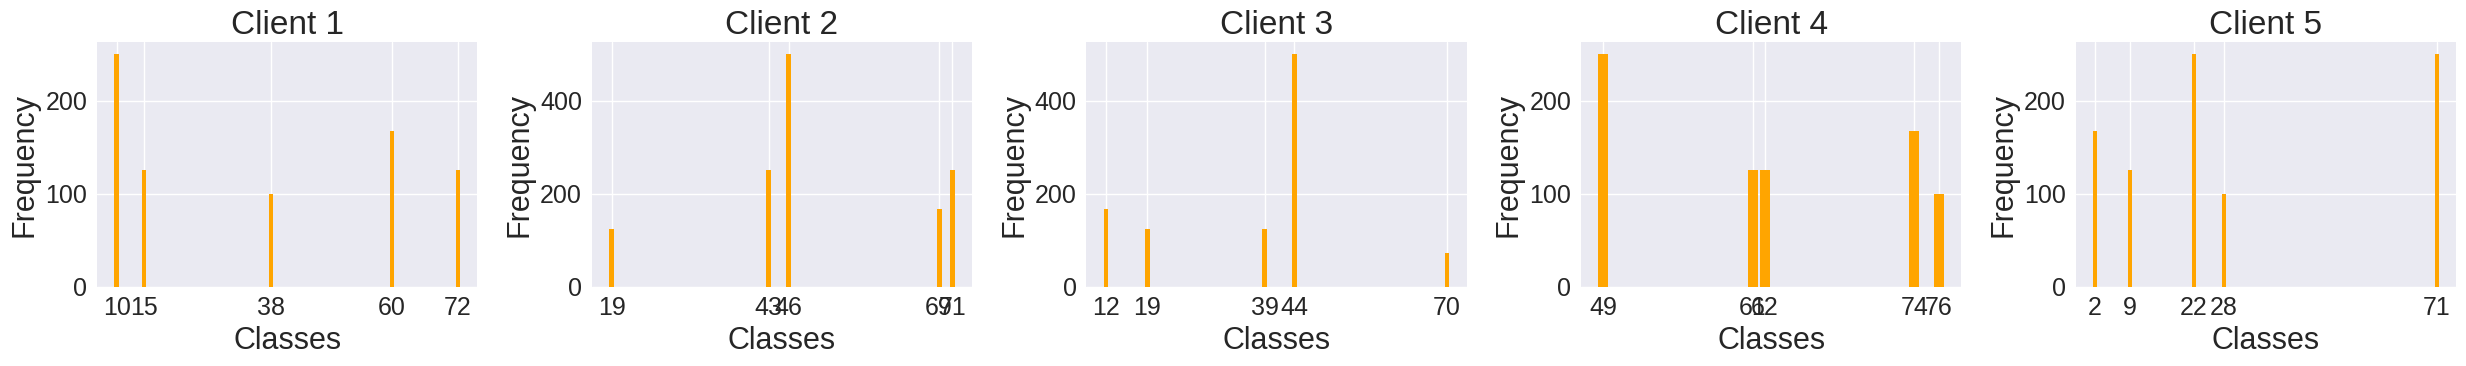

In [33]:
""" IMPORTING THE MODEL FROM OUTSIDE """

# === CREATE and LOAD MODEL on CPU ===
device_cpu = torch.device("cpu")
dino_vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_vits16 = dino_vits16.to(device_cpu)   # resta su CPU

global_model_cpu = DINOWithHead(backbone=dino_vits16, num_classes=100).to(device_cpu)
model_filename = f"global_model_FL_HEAD_{FLAG}_J{J}_Nc{Nc}_50.pth"
global_model_cpu.load_state_dict(torch.load(model_filename, map_location=device_cpu))
global_model_cpu.to(device_cpu)
global_model_cpu.train()

# === FREEZE SOLO LA HEAD, BACKBONE TRAINABLE ===
for name, param in global_model_cpu.named_parameters():
    if name.startswith("head"):
        param.requires_grad = False
    else:
        param.requires_grad = True


# === CREA LE DUE COPIE SU GPU ===
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#imported_model_calib = copy.deepcopy(global_model_cpu).to(device_gpu)
imported_model_train = copy.deepcopy(global_model_cpu).to(device_gpu)


# === IMPORTING CLIENTS ==
clients_filename = f"clients_FL_HEAD_{FLAG}_J{J}_Nc{Nc}_50.pkl"
with open(clients_filename, 'rb') as f:
    clients = pickle.load(f)

Client.plot_class_distribution(clients[0:5], tot_train_data)

In [34]:
def compute_global_fisher(clients, model, device):
    """
    Compute cumulative (global) Fisher scores over all clients without storing
    individual client Fisher scores. Returns a dictionary {param_name: fisher_score}.
    
    Args:
        clients: list of Client objects
        model: the PyTorch model
        device: 'cpu' or 'cuda'
    """
    # Initialize global Fisher scores only for trainable parameters
    global_fisher = {name: torch.zeros_like(param, device="cpu")
                     for name, param in model.named_parameters() if param.requires_grad}

    for client in clients:
        model.eval()
        for inputs, labels in client.loader:
            inputs, labels = inputs.to(device), labels.to(device)

            model.zero_grad()
            outputs = model(inputs)
            log_probs = F.log_softmax(outputs, dim=1)
            sampled_y = torch.multinomial(log_probs.exp(), num_samples=1).squeeze(-1)
            loss = F.nll_loss(log_probs, sampled_y)
            loss.backward()

            # Accumulate squared gradients into global Fisher scores
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    global_fisher[name] += (param.grad.detach().cpu() ** 2) / len(client.loader.dataset)

    return global_fisher


In [ ]:
set_seeds(123)

# === LOSS FUNCTION ===
criterion = nn.CrossEntropyLoss()

# === START TIMER ===
start_time = time.time()

# === CALIBRATION MASK ===
start_c_time = time.time()
print(f'Masking, selection method: {KEEP}')
calibrate_all_clients(
    clients, 
    imported_model_train, 
    device, 
    R=C_ROUNDS, 
    final_sparsity=SPARSITY, 
    lr=LR, 
    keep=KEEP
)
end_c_time = time.time()
c_time = round(end_c_time - start_c_time, 2)


print("Calcolating global Fisher scores before FL training...")
global_fisher_scores = compute_global_fisher(clients, imported_model_train, device)

 
# === TRAIN FL ===
best_global_model, test_losses, test_accuracies, avg_train_losses, avg_train_accuracies = train_test_model_FL(
    global_model=imported_model_train,
    criterion=criterion,
    LR=LR,
    MOMENTUM=MOMENTUM,
    WEIGHT_DECAY=WEIGHT_DECAY,
    T_MAX=T_MAX,
    clients=clients,
    val_test_loader=test_loader,
    num_epochs=N_EP,
    C=C,
    J=J,
    checkpoint_path=checkpoint_path,
    checkpoints=True,
    verbose=VERBOSE,
    use_sparse=True,     # Using sparse SGD
    global_fisher_scores=global_fisher_scores
)

end_time = time.time()
training_time = round(end_time - start_time, 2)

# === SAVING RESULTS ===
results_FL_sparse = {
    "flag": FLAG,
    "J": J,
    "Nc": Nc,
    "epochs": N_EP,
    "c_rounds": C_ROUNDS,
    "c_time": c_time,
    "sparsity": SPARSITY,
    "avg_train_losses": avg_train_losses,
    "avg_train_accuracies": avg_train_accuracies,
    "test_losses": test_losses,
    "test_accuracies": test_accuracies,
    "training_time_sec": training_time,
    "global_fisher_scores": global_fisher_scores   # <-- addition
}



Masking, selection method: least
[Round = 1] Sparsity = 0.2929
Parametri attivi: 15319937/21665664 (70.71%)
[Round = 2] Sparsity = 0.5000
Parametri attivi: 10698327/21665664 (49.38%)
✅ Client 1 -> mask calibrated (sparsity=0.5)
[Round = 1] Sparsity = 0.2929
Parametri attivi: 15319937/21665664 (70.71%)
[Round = 2] Sparsity = 0.5000
Parametri attivi: 10687349/21665664 (49.33%)
✅ Client 2 -> mask calibrated (sparsity=0.5)
[Round = 1] Sparsity = 0.2929
Parametri attivi: 15319937/21665664 (70.71%)
[Round = 2] Sparsity = 0.5000
Parametri attivi: 10760903/21665664 (49.67%)
✅ Client 3 -> mask calibrated (sparsity=0.5)
[Round = 1] Sparsity = 0.2929
Parametri attivi: 15319937/21665664 (70.71%)
[Round = 2] Sparsity = 0.5000
Parametri attivi: 10716555/21665664 (49.46%)
✅ Client 4 -> mask calibrated (sparsity=0.5)
[Round = 1] Sparsity = 0.2929
Parametri attivi: 15319937/21665664 (70.71%)
[Round = 2] Sparsity = 0.5000
Parametri attivi: 10740325/21665664 (49.57%)
✅ Client 5 -> mask calibrated (sparsi

In [ ]:
# Remove the "global_fisher_scores" field if present
if "global_fisher_scores" in results_FL_sparse:
    del results_FL_sparse["global_fisher_scores"]
    print("global_fisher_scores removed from results_FL_sparse")


✅ global_fisher_scores rimosso da results_FL_sparse


In [ ]:
# === SAVING JSON ===
json_filename = f"results_FL_FINE_TUNED_{FLAG}_J{J}_Nc{Nc}_Cal{C_ROUNDS}_S{SPARSITY}_EXTRA.json"
with open(json_filename, 'w') as f:
    json.dump(results_FL_sparse, f, indent=2)

# === SAVING WEIGHTS ===
model_filename = f"global_model_FL_FINE_TUNED_{FLAG}_J{J}_Nc{Nc}_Cal{C_ROUNDS}_S{SPARSITY}_EXTRA.pth"
torch.save(best_global_model.state_dict(), model_filename)

✅ JSON salvato: results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_EXTRA.json
✅ Modello salvato: global_model_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_EXTRA.pth
